# Image Classification

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
train_dir = '../dataset/train'
test_dir = '../dataset/test'

In [4]:
import os

def count_files_and_images(directory):
    class_counts = {}
    total_images = 0

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            file_count = len(os.listdir(class_path))
            class_counts[class_name] = file_count
            total_images += file_count

    return class_counts, total_images

train_directory = train_dir
test_directory = test_dir

train_class_counts, total_train_images = count_files_and_images(train_directory)
test_class_counts, total_test_images = count_files_and_images(test_directory)

# Print the results
print("Train Directory:")
print("Class Counts:", train_class_counts)
print("Total Train Images:", total_train_images)

print("\nTest Directory:")
print("Class Counts:", test_class_counts)
print("Total Test Images:", total_test_images)

Train Directory:
Class Counts: {'chatamari': 142, 'chhoila': 120, 'dalbhat': 205, 'dhindo': 108, 'gundruk': 80, 'kheer': 288, 'momo': 274, 'sekuwa': 125, 'selroti': 206}
Total Train Images: 1548

Test Directory:
Class Counts: {'chatamari': 36, 'chhoila': 30, 'dalbhat': 53, 'dhindo': 27, 'gundruk': 20, 'kheer': 73, 'momo': 69, 'sekuwa': 34, 'selroti': 53}
Total Test Images: 395


In [5]:
# Hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 50

num_classes = 9

# Image size
img_height = 128
img_width = 128

In [6]:
# Data preprocessing
standard_transform = transforms.Compose(
    [transforms.Resize((img_height, img_width)),
     transforms.ToTensor(),  # To convert to tensor with compatible data type i.e., float32
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # To normalize image

train_set = torchvision.datasets.ImageFolder(root=train_dir, transform=standard_transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)

test_set = torchvision.datasets.ImageFolder(root=test_dir, transform=standard_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=False)

In [7]:
classes = train_loader.dataset.classes
print(classes)

['chatamari', 'chhoila', 'dalbhat', 'dhindo', 'gundruk', 'kheer', 'momo', 'sekuwa', 'selroti']


## Data Visualiation

In [8]:
# Function to show images
def imshow(ax, img, label):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(classes[label])
    ax.axis('off')  # Hide axes

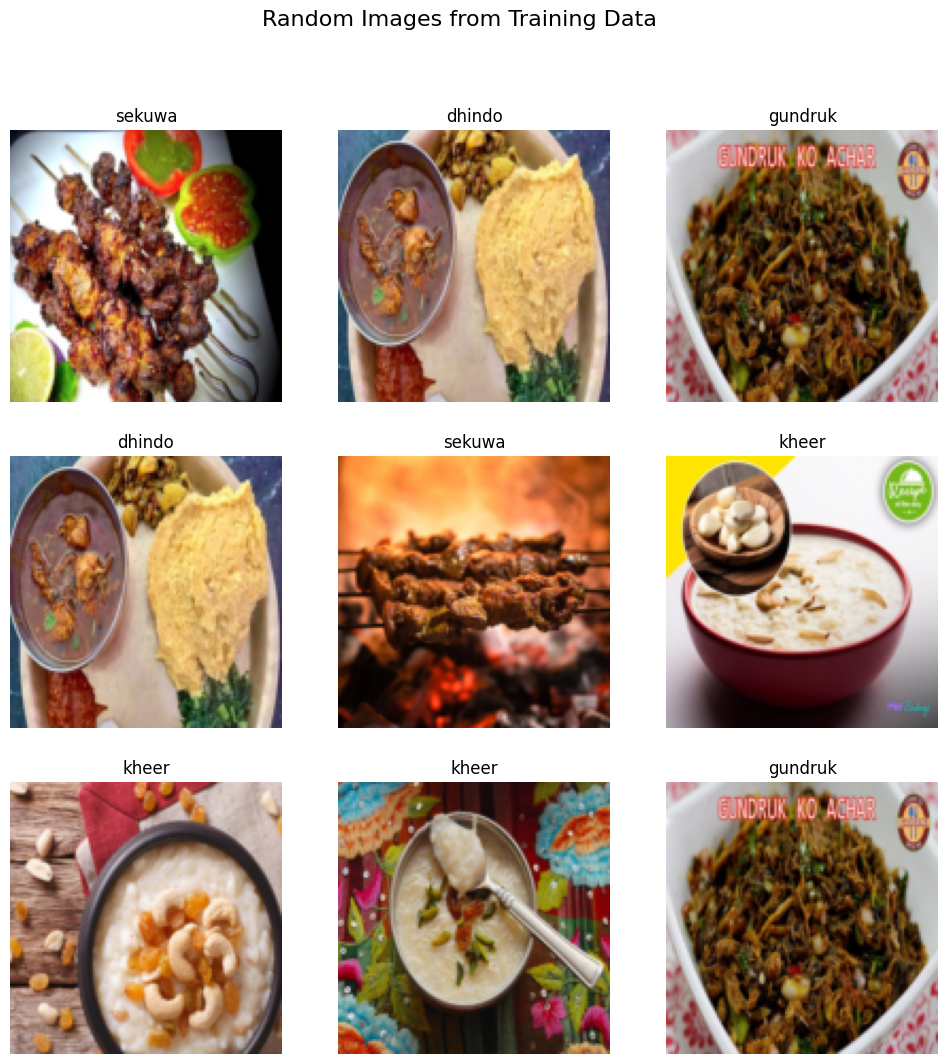

In [9]:
# Get some random training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Plot the images in a grid
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('Random Images from Training Data', fontsize=16)

for i in range(3):
    for j in range(3):
        index = np.random.randint(batch_size)
        ax = axes[i, j]
        imshow(ax, images[index], labels[index])
        ax.axis('off')

plt.show()

## Data Augmentation

In [10]:
# Define the transformations
data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=36),
    transforms.RandomAffine(degrees=0, scale=(0.9, 1.1))
])

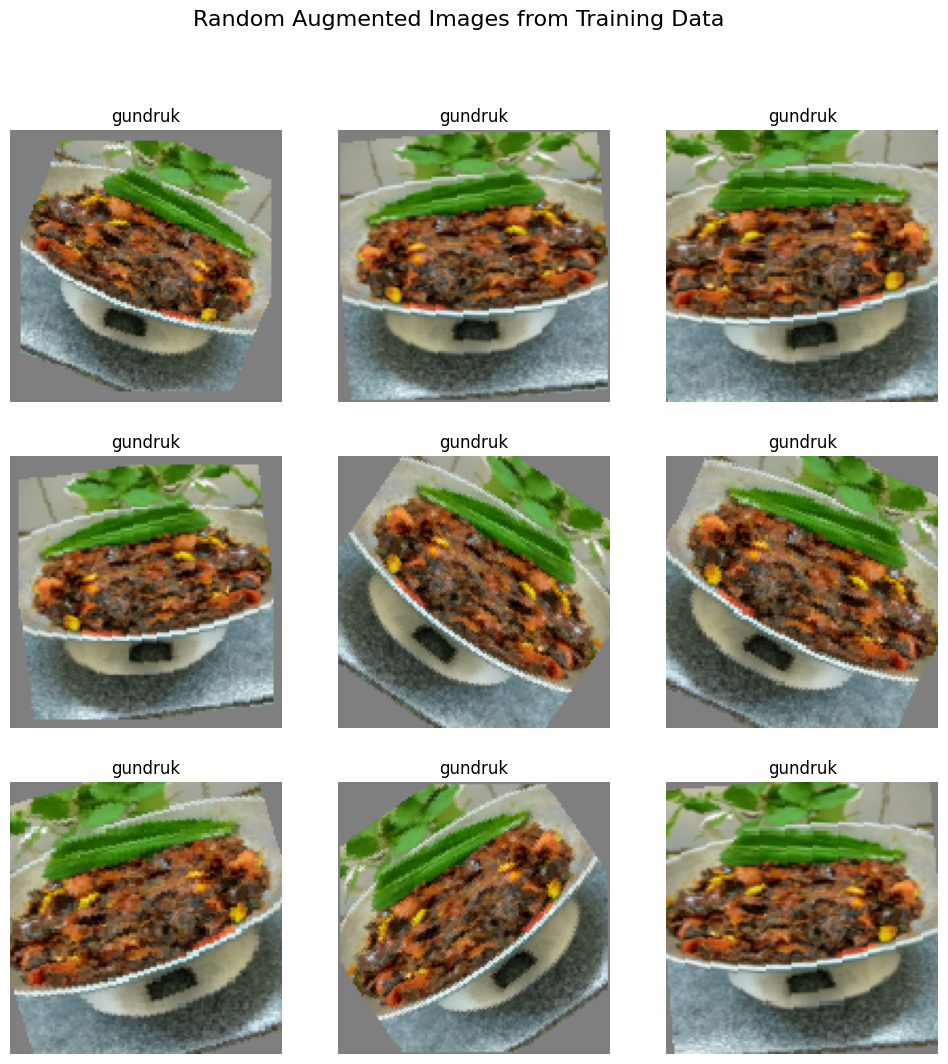

In [11]:
# Get some random training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Plot the images in a grid
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('Random Augmented Images from Training Data', fontsize=16)

index = np.random.randint(batch_size)
for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        imshow(ax, data_augmentation(images[index]), labels[index])
        ax.axis('off')

plt.show()

In [12]:
transform = transforms.Compose([
     standard_transform,
     data_augmentation])

train_set = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)

test_set = torchvision.datasets.ImageFolder(root=test_dir, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=False)

dataloaders = {'train' : train_loader,
               'test' : test_loader}

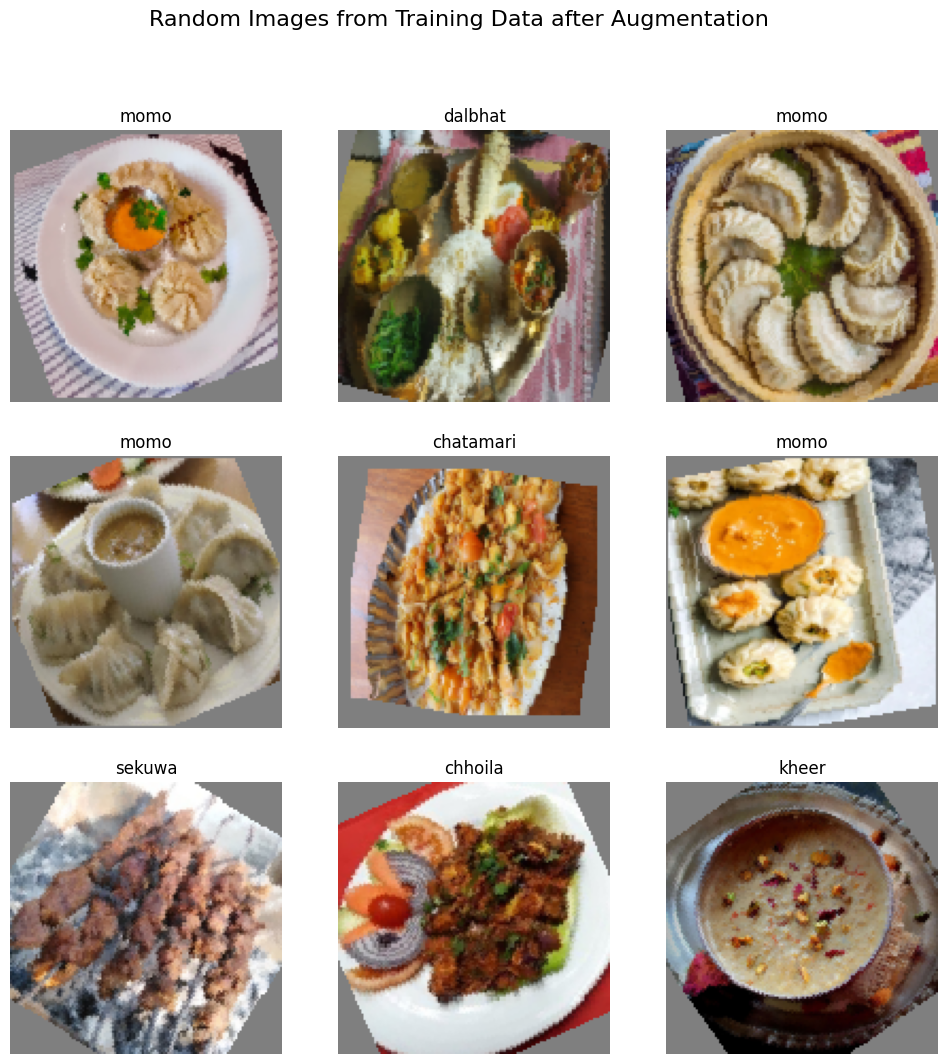

In [13]:
# Get some random training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Plot the images in a grid
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('Random Images from Training Data after Augmentation', fontsize=16)

for i in range(3):
    for j in range(3):
        index = np.random.randint(batch_size)
        ax = axes[i, j]
        imshow(ax, images[index], labels[index])
        ax.axis('off')

plt.show()

## Defining and training model

In [14]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        """
        This function initializes the layers for the CNN model
        """
        super(CNNModel, self).__init__()

        # parameters for conv layers
        filter_dim = 3
        in_channels = [3, 16, 32, 32]
        out_channels = [16, 32, 32, 64]

        # parameters for dense layers
        dense_in_features = [32*32*64, 32*64, 256]
        dense_out_features = [32*64, 256, num_classes]

        # initializing all the layers
        self.c1 = nn.Conv2d(in_channels[0], out_channels[0], filter_dim, padding='same')
        self.c2 = nn.Conv2d(in_channels[1], out_channels[1], filter_dim, padding='same')
        self.m1 = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(p=0.25)
        self.c3 = nn.Conv2d(in_channels[2], out_channels[2], filter_dim, padding='same')
        self.c4 = nn.Conv2d(in_channels[3], out_channels[3], filter_dim, padding='same')
        self.m2 = nn.MaxPool2d(2)
        self.d1 = nn.Linear(dense_in_features[0], dense_out_features[0])
        self.d2 = nn.Linear(dense_in_features[1], dense_out_features[1])
        self.d3 = nn.Linear(dense_in_features[2], dense_out_features[2])
        
    def forward(self, x):
        """
        This function performs convolutions, relu, max_pooling, dropout, 
        reshape and dense operations on the input to the model.

        Parameters
        ------------
        x : tensor, float32
        Input image to the model

        Returns
        ------------
        x : tensor, float32
        output from the last layer

        """
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = self.m1(x)
        x = self.dropout(x)
        x = F.relu(self.c3(x))
        x = F.relu(self.c4(x))
        x = self.m2(x)
        x = self.dropout(x)
        x = x.view(-1, 32*32*64)
        x = self.d1(x)
        x = F.relu(x)
        x = self.d2(x)
        x = F.relu(x)
        x = self.d3(x)
        return x

In [15]:
model = CNNModel(num_classes).to(device)

In [16]:
model.parameters

<bound method Module.parameters of CNNModel(
  (c1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (c2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (m1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (c3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (c4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (m2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (d1): Linear(in_features=65536, out_features=2048, bias=True)
  (d2): Linear(in_features=2048, out_features=256, bias=True)
  (d3): Linear(in_features=256, out_features=9, bias=True)
)>

In [18]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir = 'runs/food')

In [20]:
examples = iter(train_loader)
example_data, example_targets = next(examples)

ex_data = example_data.to(device)

writer.add_graph(model, ex_data)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [18]:
# Initialize lists to store training and validation metrics
train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []

best_val_acc = 0.0

# Training loop
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 30)

    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        corrects = 0
        total_samples = 0

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)

            with torch.set_grad_enabled(phase == 'train'):
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

        epoch_loss = running_loss / total_samples
        epoch_acc = corrects.double() / total_samples

        print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Store metrics in history lists
        if phase == 'train':
            train_acc_history.append(epoch_acc)
            train_loss_history.append(epoch_loss)
        else:
            val_acc_history.append(epoch_acc)
            val_loss_history.append(epoch_loss)

        # Save the model if it has the best validation accuracy
            if epoch_acc > best_val_acc:
                best_val_acc = epoch_acc
                best_model_weights = model.state_dict()

Epoch 1/50
------------------------------
Train Loss: 2.0594 Acc: 0.2145
Test Loss: 1.9204 Acc: 0.2532
Epoch 2/50
------------------------------
Train Loss: 1.7942 Acc: 0.3320
Test Loss: 1.8639 Acc: 0.2759
Epoch 3/50
------------------------------
Train Loss: 1.7304 Acc: 0.3417
Test Loss: 1.8105 Acc: 0.3241
Epoch 4/50
------------------------------
Train Loss: 1.7075 Acc: 0.3527
Test Loss: 1.7333 Acc: 0.3215
Epoch 5/50
------------------------------
Train Loss: 1.6646 Acc: 0.3753
Test Loss: 1.7536 Acc: 0.3367
Epoch 6/50
------------------------------
Train Loss: 1.6221 Acc: 0.3857
Test Loss: 1.7269 Acc: 0.3468
Epoch 7/50
------------------------------
Train Loss: 1.5996 Acc: 0.3908
Test Loss: 1.7165 Acc: 0.3595
Epoch 8/50
------------------------------
Train Loss: 1.5847 Acc: 0.3999
Test Loss: 1.6380 Acc: 0.3873
Epoch 9/50
------------------------------
Train Loss: 1.5431 Acc: 0.4348
Test Loss: 1.7612 Acc: 0.3671
Epoch 10/50
------------------------------
Train Loss: 1.4901 Acc: 0.4393

In [70]:
# Saving the model
torch.save(best_model_weights, 'model.pth')

## Visualize training result

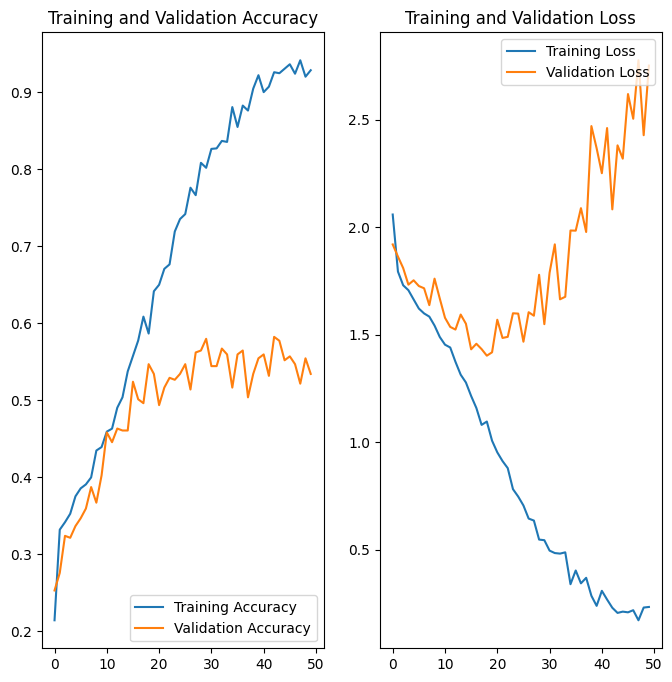

In [26]:
acc = [a.to('cpu') for a in train_acc_history]
val_acc = [v.to('cpu') for v in val_acc_history]

loss = train_loss_history[:]
val_loss = val_loss_history[:]

epochs_range = list(range(num_epochs))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predicting on new data

In [27]:
def predict_image(model, image_path):
    img_height = 128
    img_width = 128

    class_names = ['chatamari', 'chhoila', 'dalbhat', 'dhindo', 'gundruk', 'kheer', 'momo', 'sekuwa', 'selroti']
    
    # Load and preprocess the image
    transform = transforms.Compose(
        [transforms.Resize((img_height, img_width)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension

    # Move the image to the GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image = image.to(device)

    # Make predictions
    model.eval()
    with torch.no_grad():
        predictions = model(image)

    # Convert predictions to probabilities
    probs = torch.nn.functional.softmax(predictions[0], dim=0)

    # Get the predicted class index and confidence
    predicted_class_idx = torch.argmax(probs).item()
    confidence = 100 * probs[predicted_class_idx].item()

    # Return the result
    result = {
        "predicted_class": class_names[predicted_class_idx],
        "confidence": confidence
    }
    return result

In [51]:
from IPython.display import Image as I

This image most likely belongs to momo with a 100.00% confidence.


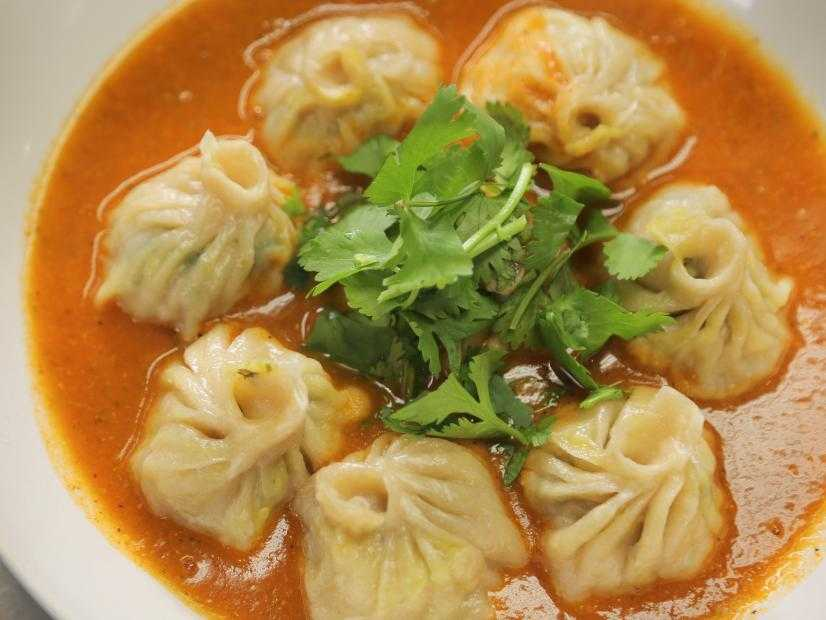

In [62]:
# Example usages
img_path = "../images/test1.jpg"
prediction_result = predict_image(model, img_path)

print(f"This image most likely belongs to {prediction_result['predicted_class']} with a {prediction_result['confidence']:.2f}% confidence.")
I(filename = img_path, width=400, height=200)

This image most likely belongs to dalbhat with a 98.95% confidence.


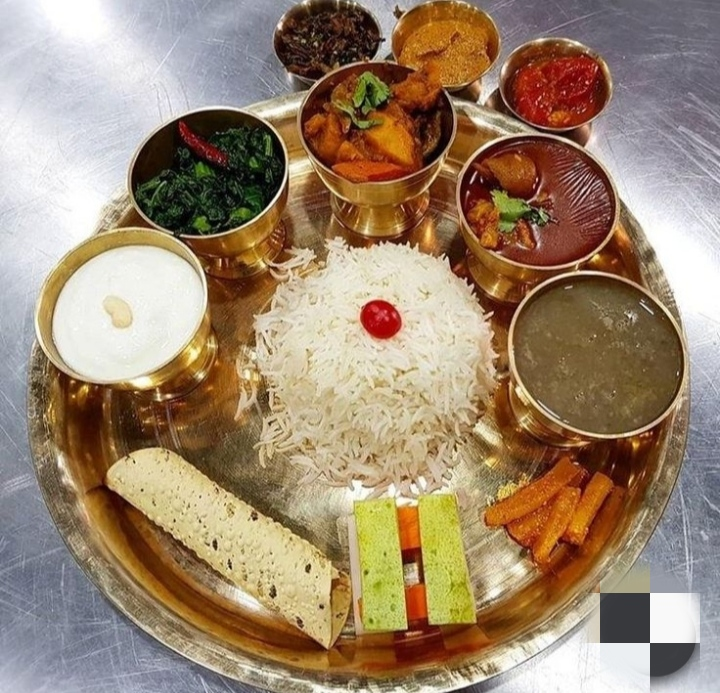

In [63]:
# Example usages
img_path = "../images/test2.jpg"
prediction_result = predict_image(model, img_path)

print(f"This image most likely belongs to {prediction_result['predicted_class']} with a {prediction_result['confidence']:.2f}% confidence.")
I(filename = img_path, width=400, height=200)

This image most likely belongs to selroti with a 99.72% confidence.


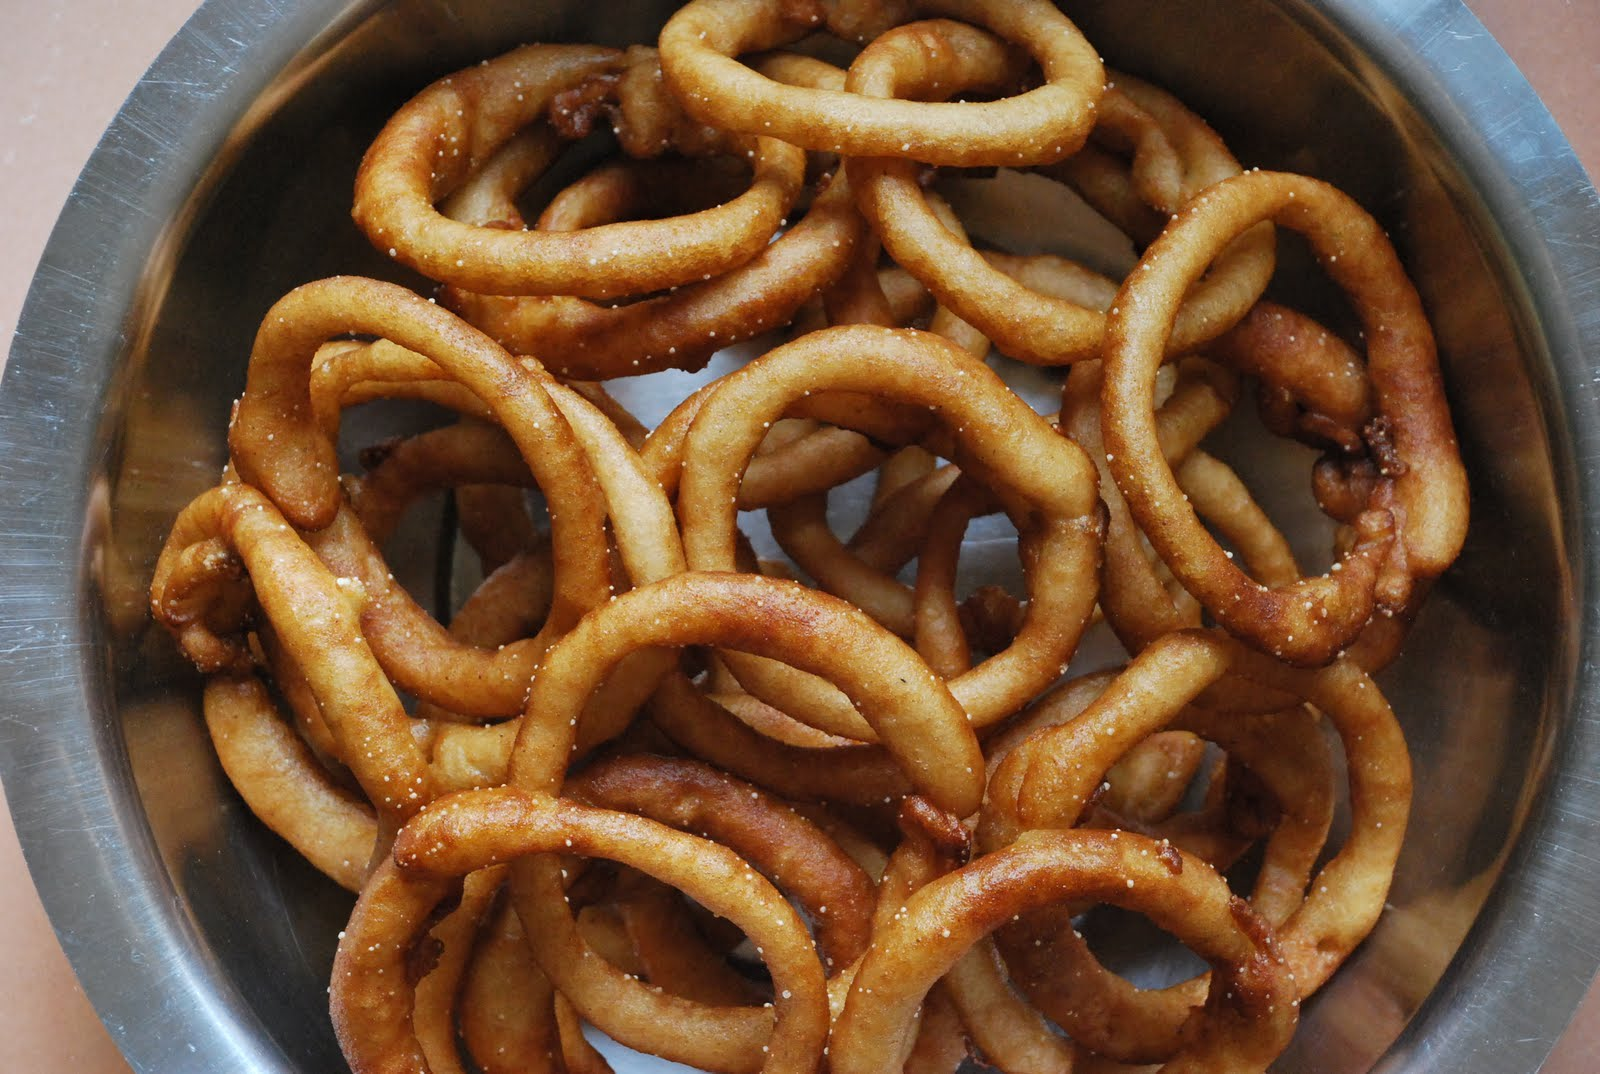

In [64]:
# Example usages
img_path = "../images/test3.jpg"
prediction_result = predict_image(model, img_path)

print(f"This image most likely belongs to {prediction_result['predicted_class']} with a {prediction_result['confidence']:.2f}% confidence.")
I(filename = img_path, width=400, height=200)

This image most likely belongs to selroti with a 74.87% confidence.


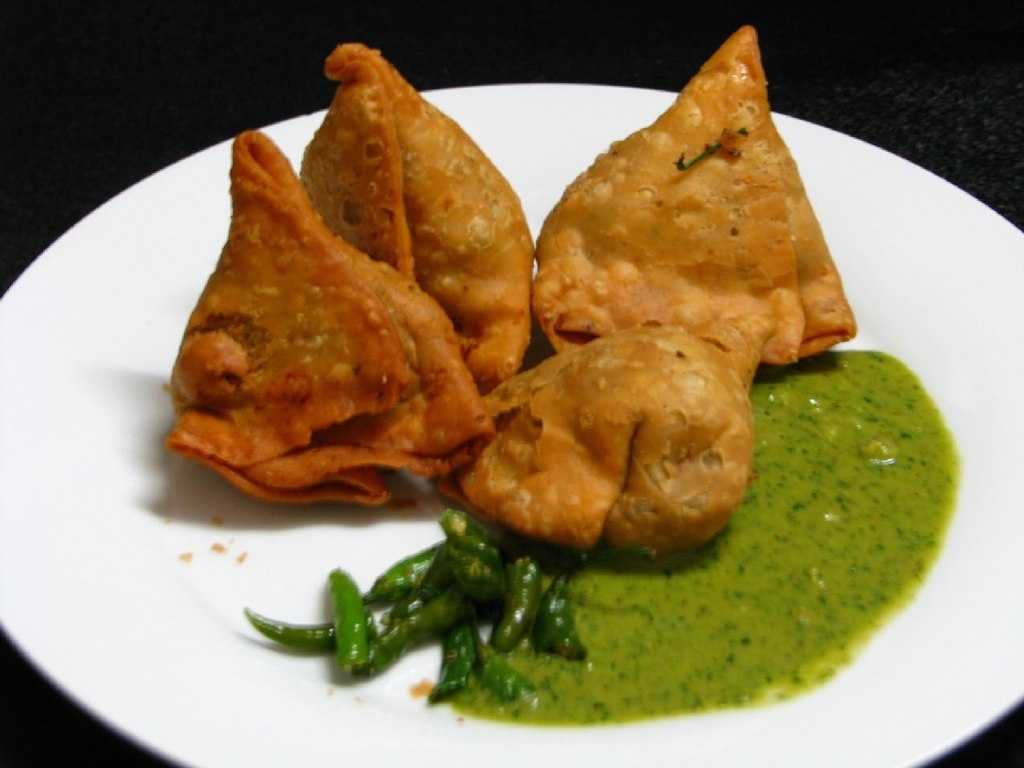

In [65]:
# Let's try with food that is not a category (Samosa)
img_path = "../images/test4.jpg"
prediction_result = predict_image(model, img_path)

print(f"This image most likely belongs to {prediction_result['predicted_class']} with a {prediction_result['confidence']:.2f}% confidence.")
I(filename = img_path, width=400, height=200)

This image most likely belongs to chatamari with a 53.10% confidence.


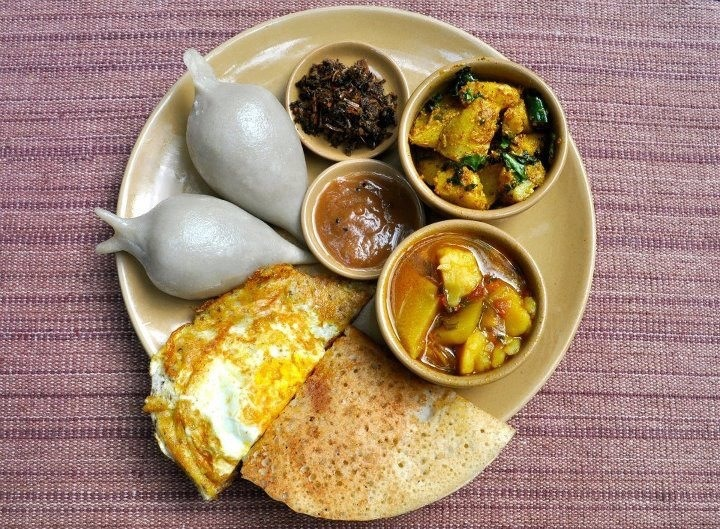

In [66]:
# One more
img_path = "../images/test5.jpg"
prediction_result = predict_image(model, img_path)

print(f"This image most likely belongs to {prediction_result['predicted_class']} with a {prediction_result['confidence']:.2f}% confidence.")
I(filename = img_path, width=400, height=200)

This image most likely belongs to chatamari with a 59.37% confidence.


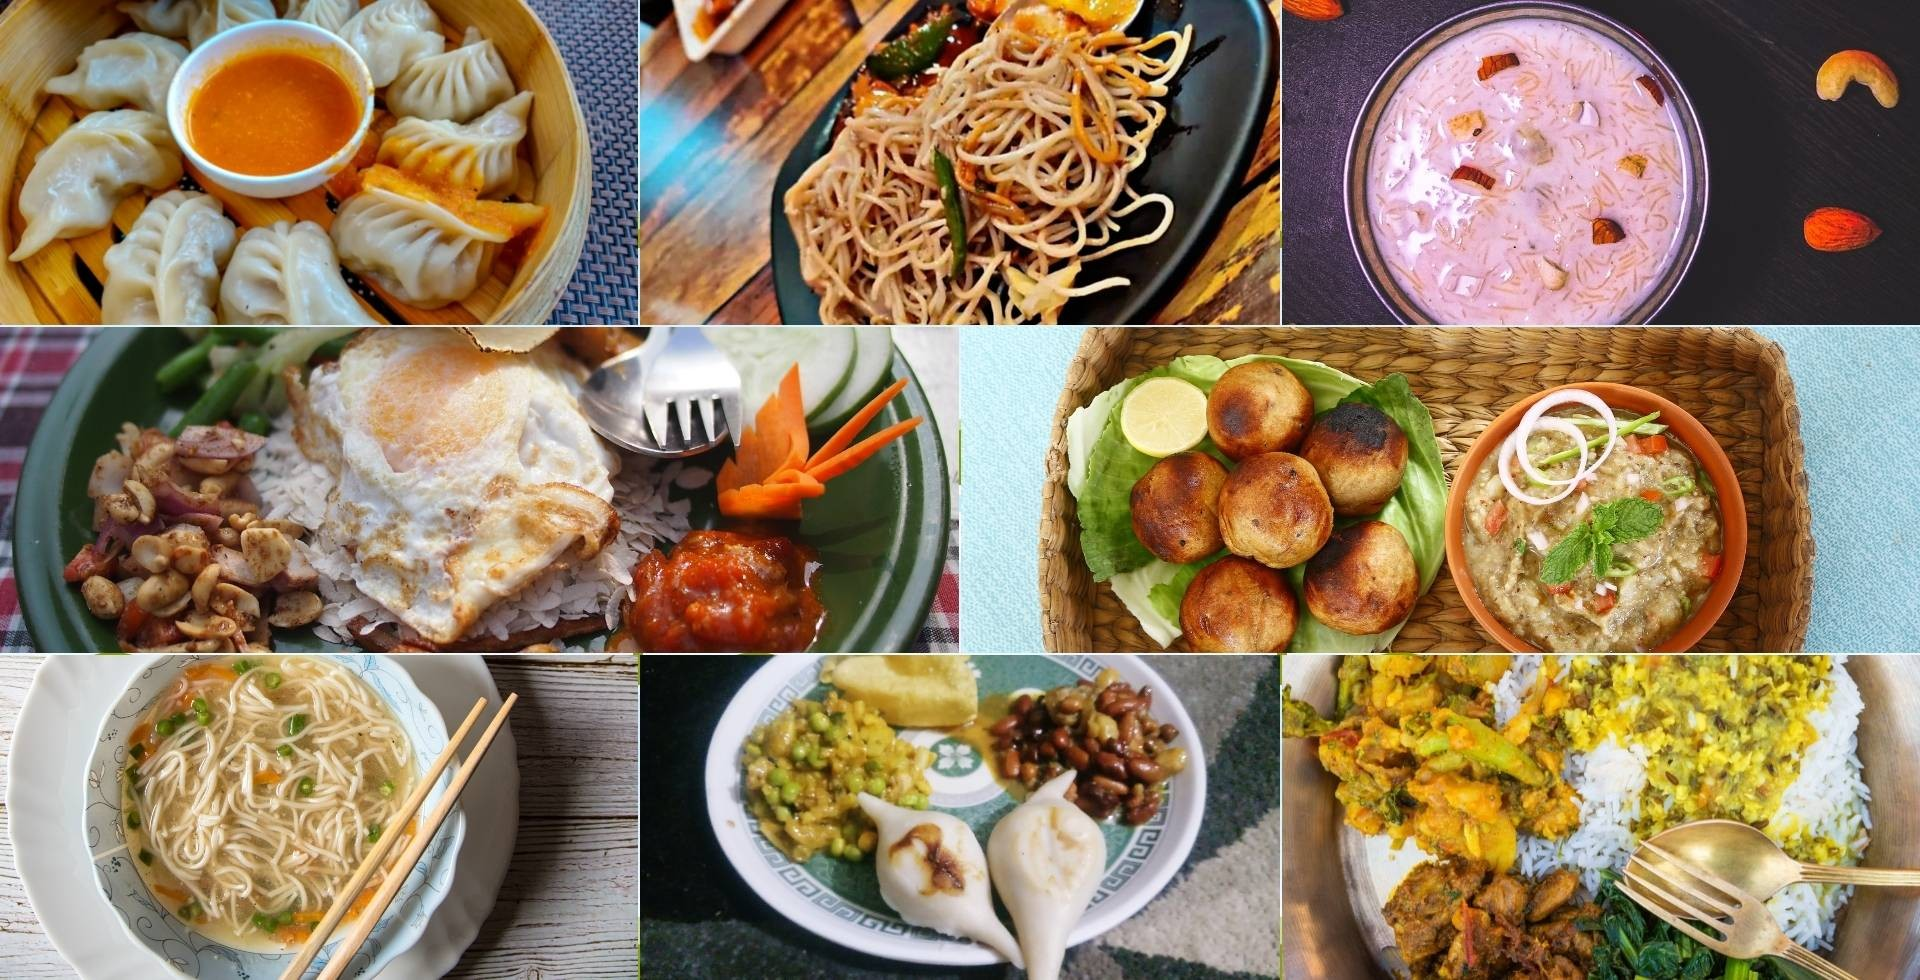

In [67]:
# Lastly try with combined food
img_path = "../images/test6.jpg"
prediction_result = predict_image(model, img_path)

print(f"This image most likely belongs to {prediction_result['predicted_class']} with a {prediction_result['confidence']:.2f}% confidence.")
I(filename = img_path, width=400, height=200)